 # Training and Health Analysis

 ## Training data
 ### We start by importing the data and cleaning it

 I did a rough cleaning of the data in Power BI in order to more easily see what data to remove and change. Then for the more thorough cleaning I import all the data from csv-files into python with pandas.

In [1]:
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np


In [2]:
import pandas as pd
import seaborn as sns


# df = pd.read_csv("data/November 2022 full body merged.csv", sep=";")

df = pd.read_csv("data/Trainingdata Rough Clean.csv")

df.rename(columns={"excercise": "exercise"}, inplace=True)
df.exercise = df.exercise.str.lower()
df = df[df.Date.str.contains("Date") == False]
df.head()


,Date,exercise,set 1 reps,set 1 weight,set 2 reps,set 2 weight,set 3 reps,set 3 weight,set 4 reps,set 4 weight
0,2022-03-04 00:00:00,atg split squat,5,34,7,29,7,29,0,0
1,2022-02-15 00:00:00,atg split squat,6,29,6,29,5,29,0,0
2,2022-03-22 00:00:00,atg split squat,6,31.5,6,31.5,5,31.5,0,0
3,2022-03-31 00:00:00,atg split squat,6,31.5,6,31.5,6,31.5,0,0
4,2022-03-12 00:00:00,atg split squat,6,34,6,31.5,6,31.5,0,0


 I first need to fix the dates so I can easily sort by year month and day.

In [3]:
df["date"] = pd.to_datetime(df.Date)
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day

df.head()


,Date,exercise,set 1 reps,set 1 weight,set 2 reps,set 2 weight,set 3 reps,set 3 weight,set 4 reps,set 4 weight,date,year,month,day
0,2022-03-04 00:00:00,atg split squat,5,34,7,29,7,29,0,0,2022-03-04,2022,3,4
1,2022-02-15 00:00:00,atg split squat,6,29,6,29,5,29,0,0,2022-02-15,2022,2,15
2,2022-03-22 00:00:00,atg split squat,6,31.5,6,31.5,5,31.5,0,0,2022-03-22,2022,3,22
3,2022-03-31 00:00:00,atg split squat,6,31.5,6,31.5,6,31.5,0,0,2022-03-31,2022,3,31
4,2022-03-12 00:00:00,atg split squat,6,34,6,31.5,6,31.5,0,0,2022-03-12,2022,3,12


 I also want the reps and weights for all the sets in the same column so i need to do some manipulation here.

In [4]:
# melt the dataframe into a long format
melted_df = pd.melt(
    df,
    id_vars=["year", "month", "day", "exercise"],
    value_vars=[
        "set 1 reps",
        "set 2 reps",
        "set 3 reps",
        "set 4 reps",
        "set 1 weight",
        "set 2 weight",
        "set 3 weight",
        "set 4 weight",
    ],
    var_name="set",
    value_name="values",
)


# separate the 'set' column into 'set number' and 'metric' columns
melted_df[["set_name", "set #", "type"]] = melted_df["set"].str.split(" ", expand=True)

# drop the original 'set' column
melted_df = melted_df.drop(columns=["set"])

# pivot the dataframe to get reps and weights in separate columns
pivoted_df = melted_df.pivot_table(
    index=["year", "month", "day", "exercise", "set #"], columns="type", values="values"
).reset_index()

pivoted_df.head()


type,year,month,day,exercise,set #,reps,weight
0,2021,12,3,barbell hacksquat,1,5.0,85.0
1,2021,12,3,barbell hacksquat,2,5.0,80.0
2,2021,12,3,barbell hacksquat,3,5.0,75.0
3,2021,12,3,barbell hacksquat,4,0.0,0.0
4,2021,12,3,rdls,1,18.0,60.0


 Now it looks like I want it to, however, I want to remove the 'type' column header, which could be done by exporting the dataframe without index.

In [5]:
# removed type column by exporting
pivoted_df.to_csv("data/Trainingdata remove index.csv", index=False)


In [6]:
df_training = pd.read_csv("data/Trainingdata remove index.csv")
df_training = df_training.set_index(["year", "month", "day"])
df_training = df_training[df_training["reps"] != 0]

df_training.head(10)


exercise  set #  reps  weight
year month day                                        
2021 12    3    barbell hacksquat      1   5.0    85.0
           3    barbell hacksquat      2   5.0    80.0
           3    barbell hacksquat      3   5.0    75.0
           3                 rdls      1  18.0    60.0
           3                 rdls      2  16.0    60.0
           3                 rdls      3  15.0    60.0
           3      reverse nordics      1  12.0     0.0
           3      reverse nordics      2  12.0     0.0
           3      reverse nordics      3  12.0     0.0
           3     single leg hyper      1   8.0     0.0

 We fix the index, and also remove all sets where I have done zero reps.

In [7]:
df_training = df_training[df_training["exercise"].str.contains("band") == False]

print("Number of different exercises: ", df_training["exercise"].nunique())


Number of different exercises:  77


 I also removed all the exercises containing the word band, since I dont have a weight value for those.

In [8]:
exercise_rename_list = {
    "rdls": "romanian deadlifts",
    "regular dl": "deadlifts",
    "utfall": "lunges",
    "utfall?": "lunges",
    "bw lunges": "lunges",
    "bw hypers": "hyperextensions",
    "hyper extensions": "hyperextensions",
    "hypers": "hyperextensions",
    "hyperextension": "hyperextensions",
    "militärpress": "overhead press",
    "axelpress": "db shoulder press",
    "back squat": "squats",
    "backsquats": "squats",
    "bench press (pause)": "bench press",
    "larsen press": "bench press",
    "bw pullups": "pull ups",
    "pullups": "pull ups",
    "pull ups*": "pull ups",
    "weighted pull ups": "pull ups",
    "weighted chin ups": "chin ups",
    "barbell benchpress": "bench press",
    "weighted push ups": "push ups",
    "weighted push up": "push ups",
    "sissy sqauts": "sissy squats",
    "biceps": "bicep curls",
    "bw atg split squats": "atg split squats",
    "atg split squat": "atg split squats",
    "oblique maskin": "obliques",
    "delt row": "inverted delt rows",
    "inverted delt row": "inverted delt rows",
    "rear delt row": "wide grip rows",
    "wide row": "wide grip rows",
    "trx rows": "inverted rows",
    "ring rows": "inverted rows",
    "inverted row": "inverted rows",
    "single leg machine curls": "hamstring curls",
    "leg curls": "hamstring curls",
}

df_training["exercise"] = df_training["exercise"].replace(exercise_rename_list)
print("All exercises:\n", df_training.exercise.unique())
print("\nNumber of different exercises: ", df_training.exercise.nunique())


All exercises:
 ['barbell hacksquat' 'romanian deadlifts' 'reverse nordics'
 'single leg hyper' 'tibialis raise' 'bench press' 'bicep curls' 'dips'
 'incline db press' 'wide grip rows' 'side lateral' 'calves'
 'hamstring curls' 'leg press' 'obliques' 'quad extensions' 'sumo dl'
 'close grip row' 'overhead press' 'single leg hyper extensions'
 'straight arm pulldown' 'triceps' 'pull ups' 'decline push ups'
 'push ups' 'y raise' 'db shoulder press' 'hyperextensions'
 'barbell curls' 'atg split squats' 'nordic curls' 'lunges'
 'laying leg raise' 'machine press' 'chin ups' 'sissy squats'
 'decline press' 'inverted rows' 'lat pulldown' 'ring push ups'
 'inverted delt rows' 'deadlifts' 'beltsquat' 'squats' 'tricep extensions'
 'squat (pin)' 'one arm lat pulldown' 'good mornings'
 'atg heel elevated squat' 'db curls' 'ring curls' 'squat (pause)'
 'leg extensions' 'tricep pushdowns' 'pullover']

Number of different exercises:  55


In [9]:
print(
    "\nTop 10 number of sets of each exercise:\n",
    df_training["exercise"].value_counts().head(10),
)



Top 10 number of sets of each exercise:
 hamstring curls          147
sumo dl                  122
straight arm pulldown    102
side lateral             102
push ups                 100
inverted rows             93
pull ups                  92
squats                    88
reverse nordics           76
romanian deadlifts        74
Name: exercise, dtype: int64


In [10]:
df_training = df_training.groupby("exercise").filter(lambda x: len(x) > 4)

print(
    "\nTop 10 number of sets of each exercise:\n",
    df_training["exercise"].value_counts().head(10),
)
print("\nNumber of different exercises: ", df_training.exercise.nunique())



Top 10 number of sets of each exercise:
 hamstring curls          147
sumo dl                  122
side lateral             102
straight arm pulldown    102
push ups                 100
inverted rows             93
pull ups                  92
squats                    88
reverse nordics           76
romanian deadlifts        74
Name: exercise, dtype: int64

Number of different exercises:  41


 ## Weight data
 ### Start with cleaning

 This time I can put the raw data directly in python because it is already pretty well structured.

In [11]:
df = pd.read_csv("data/weight.csv")
df = df.drop(
    columns=[
        "Fat mass (kg)",
        "Bone mass (kg)",
        "Muscle mass (kg)",
        "Hydration (kg)",
        "Comments",
    ],
    axis=1,
)
df = df.rename(columns={"Date": "date", "Weight (kg)": "bodyweight"})

df.head()


,date,bodyweight
0,2023-02-24 09:35:18,79.80
1,2023-02-23 09:18:48,80.07
2,2023-02-22 10:32:51,80.74
3,2023-02-21 09:58:52,80.18
4,2023-02-20 08:57:37,80.27


In [12]:
df["date"] = pd.to_datetime(df.date)
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df = df.drop("date", axis=1)
df = df.set_index(["year", "month", "day"])
df = df.iloc[::-1]

df.head()


bodyweight
year month day            
2021 10    21        76.72
           21        75.29
           22        74.80
           22        73.96
           22        74.37

 We fixed the multi-index in the same way as the training data, but there are multiple entries for the same day.

 We will take the mean for those and include only one entry per day.

In [13]:
df = df.groupby(["year", "month", "day"]).mean()
df_weight = df
df_weight.head(10)


bodyweight
year month day            
2021 10    21      76.0050
           22      74.2250
           23      74.9100
           24      75.0050
           25      74.8225
           26      74.7950
           27      74.4400
           28      74.8900
           29      74.1200
           30      74.9200

 Now it looks like how I want it.

 We can then join all the data tables on the index

In [14]:
df = df_training.join(df_weight, None, how="left")

df = df.reset_index(level=["year", "month", "day"])
df["date"] = pd.to_datetime(df[["year", "month", "day"]])
df = df.drop(["year", "month", "day"], axis=1)
df.head()


,exercise,set #,reps,weight,bodyweight,date
0,barbell hacksquat,1,5.0,85.0,73.68,2021-12-03
1,barbell hacksquat,2,5.0,80.0,73.68,2021-12-03
2,barbell hacksquat,3,5.0,75.0,73.68,2021-12-03
3,romanian deadlifts,1,18.0,60.0,73.68,2021-12-03
4,romanian deadlifts,2,16.0,60.0,73.68,2021-12-03


In [15]:
df = df.dropna(subset=["exercise"])

# df.to_csv('data/Training and Weight data clean.csv', index=False)

df.set_index("date", inplace=True)


In [16]:
# Calculating tonnage

df["tonnage"] = (
    df["weight"] * df["reps"] * df["set #"].count() / 1000
)  # Divide by 1000 to get tonnes
df["tonnage_avg"] = df["tonnage"].rolling(window=100).mean()


<ipython-input-17-75fad7565443>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_weekly = df.resample("W").mean()
<ipython-input-17-75fad7565443>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly = df.resample("M").mean()


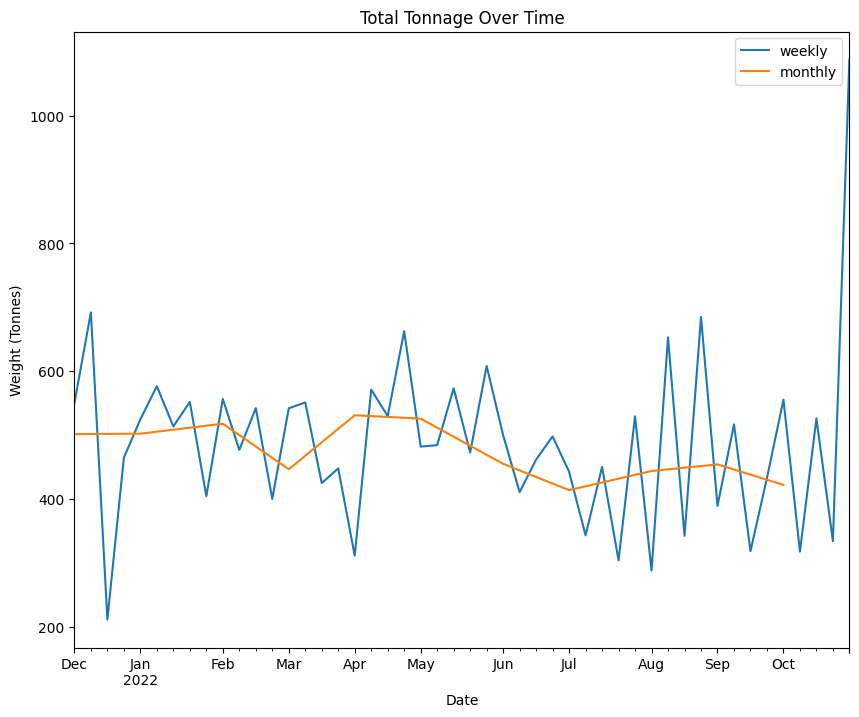

In [17]:
# Total tonnage resampled weekly and monthly to mmore easily visualize
df_weekly = df.resample("W").mean()
df_monthly = df.resample("M").mean()

df_weekly["tonnage"].plot(kind="line", figsize=(10, 8))
df_monthly["tonnage"].plot(kind="line", figsize=(10, 8))
plt.title("Total Tonnage Over Time")
plt.xlabel("Date")
plt.ylabel("Weight (Tonnes)")
plt.legend(["weekly", "monthly"])


Text(0, 0.5, 'Total Count')

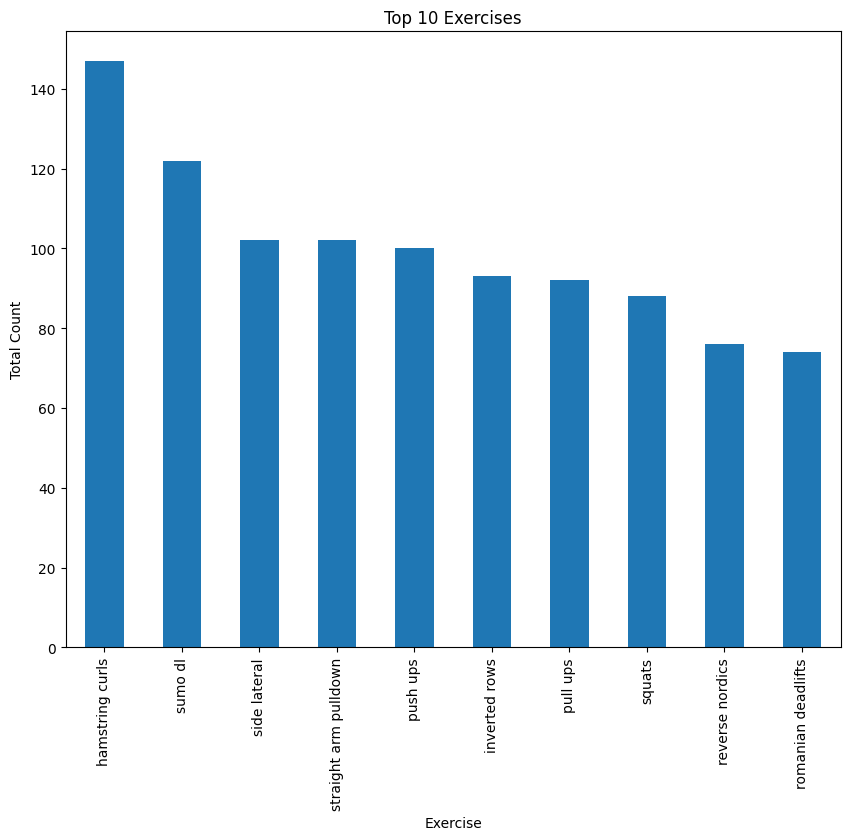

In [18]:
# Top 10 Exercises
df["exercise"].value_counts().nlargest(10).plot(kind="bar", figsize=(10, 8))
plt.title("Top 10 Exercises")
plt.xlabel("Exercise")
plt.ylabel("Total Count")


<ipython-input-19-0261f94bad3b>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exercise_df["tonnage"] = (
<ipython-input-19-0261f94bad3b>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exercise_df["tonnage"] = (
<ipython-input-19-0261f94bad3b>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

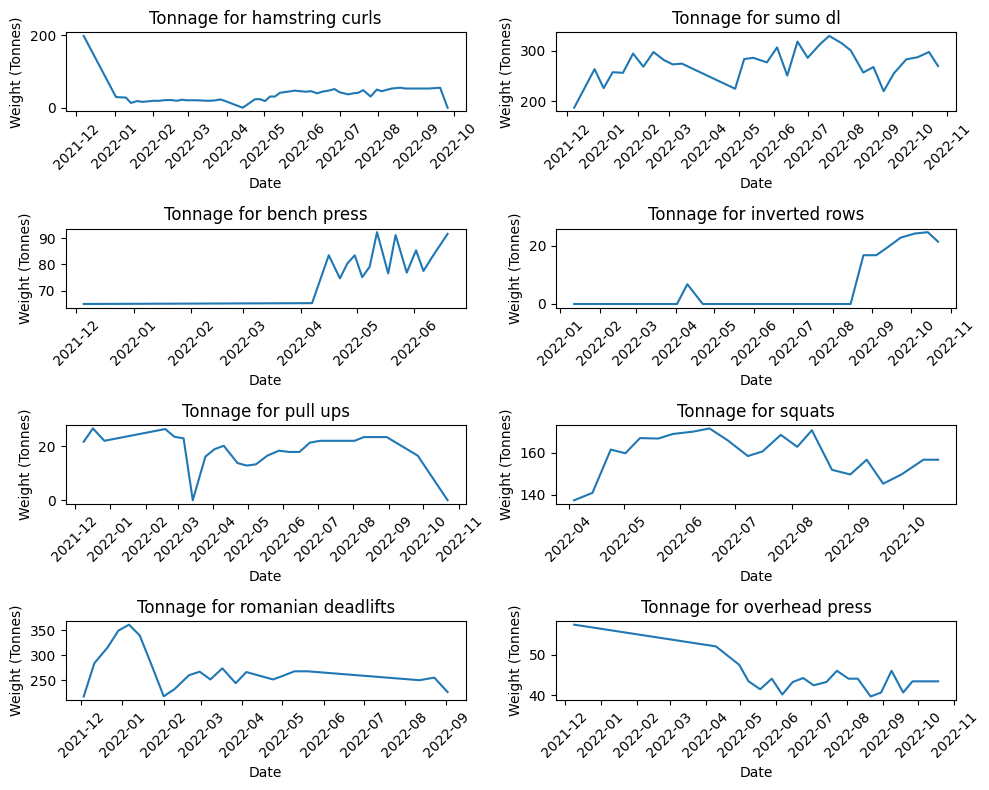

In [19]:
# Tonnage line graphs
exercise_names = [
    "hamstring curls",
    "sumo dl",
    "bench press",
    "inverted rows",
    "pull ups",
    "squats",
    "romanian deadlifts",
    "overhead press",
]

fig, axs = plt.subplots(4, 2, figsize=(10, 8))

for i, exercise_name in enumerate(exercise_names):
    row = i // 2
    col = i % 2
    exercise_df = df[df["exercise"] == exercise_name]
    exercise_df["tonnage"] = (
        exercise_df["weight"]
        * exercise_df["reps"]
        * exercise_df["set #"].count()
        / 1000
    )  # Divide by 1000 to get tonnes
    grouped_df = exercise_df.groupby("date")["tonnage"].sum().reset_index()
    axs[row, col].plot(grouped_df["date"], grouped_df["tonnage"])
    axs[row, col].set_title(f"Tonnage for {exercise_name}")
    axs[row, col].set_xlabel("Date")
    axs[row, col].set_ylabel("Weight (Tonnes)")
    axs[row, col].tick_params(axis="x", rotation=45)

plt.tight_layout()


<ipython-input-20-338f99c1ae4e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exercise_df["tonnage"] = (
<ipython-input-20-338f99c1ae4e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exercise_df["tonnage"] = (
<ipython-input-20-338f99c1ae4e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

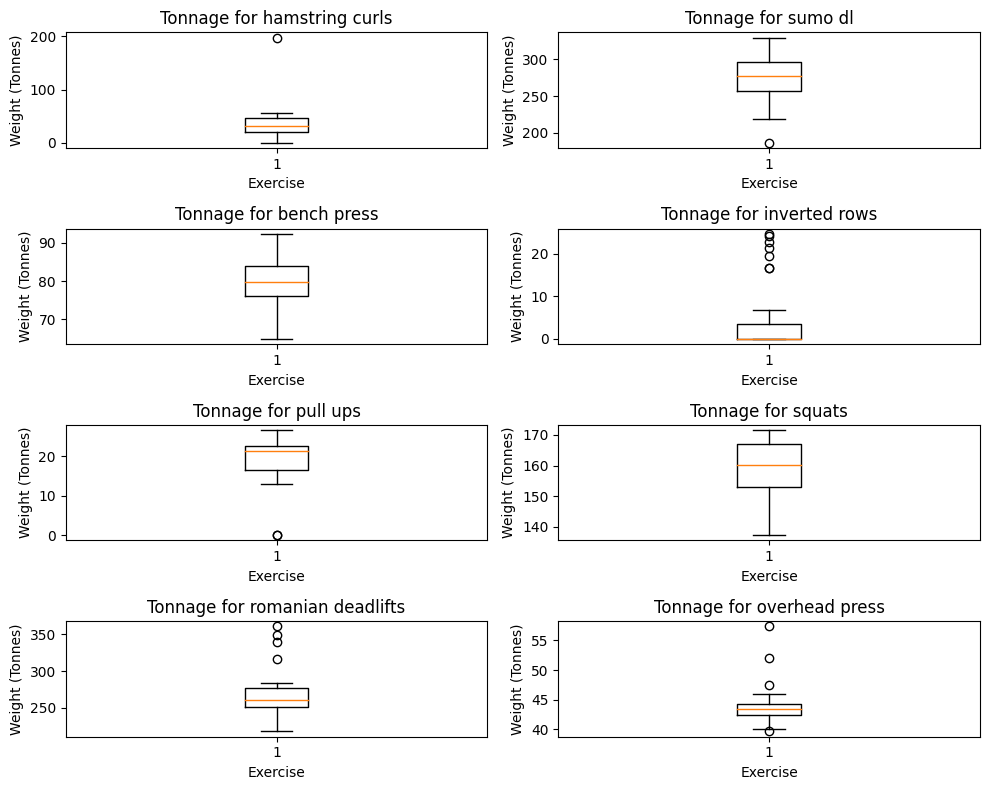

In [20]:
# Tonnage Boxplots
exercise_names = [
    "hamstring curls",
    "sumo dl",
    "bench press",
    "inverted rows",
    "pull ups",
    "squats",
    "romanian deadlifts",
    "overhead press",
]

fig, axs = plt.subplots(4, 2, figsize=(10, 8))

for i, exercise_name in enumerate(exercise_names):
    row = i // 2
    col = i % 2
    exercise_df = df[df["exercise"] == exercise_name]
    exercise_df["tonnage"] = (
        exercise_df["weight"]
        * exercise_df["reps"]
        * exercise_df["set #"].count()
        / 1000
    )  # Divide by 1000 to get tonnes
    grouped_df = exercise_df.groupby("date")["tonnage"].sum().reset_index()
    axs[row, col].boxplot(grouped_df["tonnage"])
    axs[row, col].set_title(f"Tonnage for {exercise_name}")
    axs[row, col].set_xlabel("Exercise")
    axs[row, col].set_ylabel("Weight (Tonnes)")

plt.tight_layout()


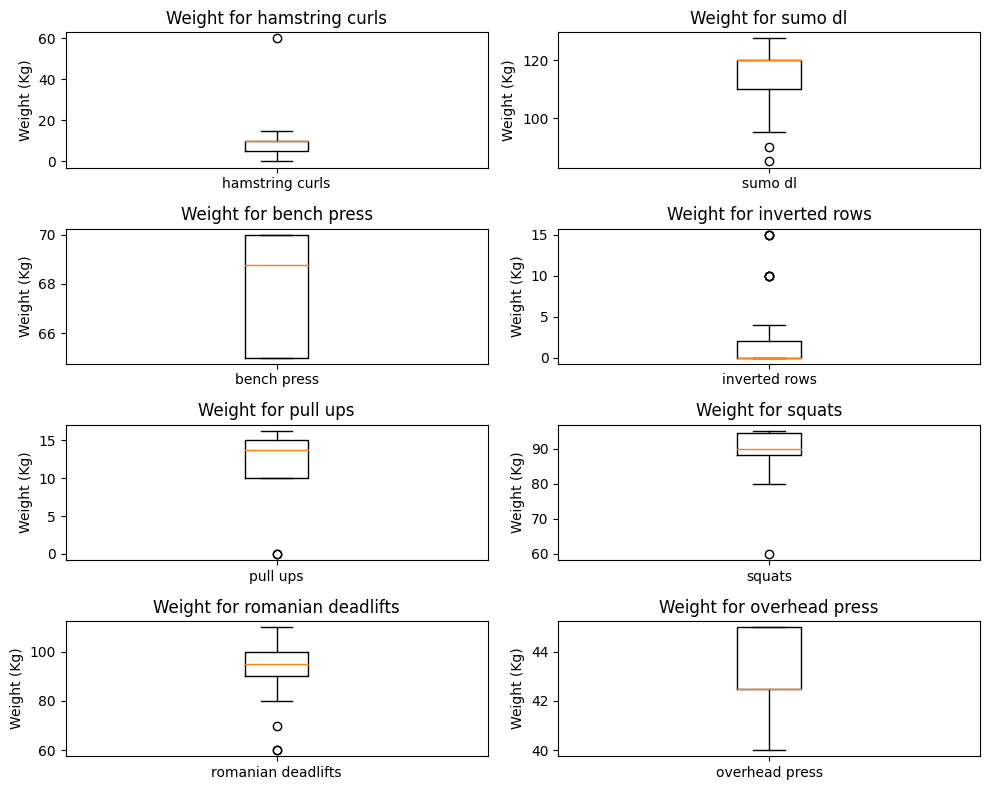

In [21]:
# Weight box plots
exercise_names = [
    "hamstring curls",
    "sumo dl",
    "bench press",
    "inverted rows",
    "pull ups",
    "squats",
    "romanian deadlifts",
    "overhead press",
]

fig, axs = plt.subplots(4, 2, figsize=(10, 8))

for i, exercise_name in enumerate(exercise_names):
    row = i // 2
    col = i % 2
    exercise_df = df[df["exercise"] == exercise_name]
    grouped_df = exercise_df.groupby("date")["weight"].max().reset_index()
    axs[row, col].boxplot(grouped_df["weight"])
    axs[row, col].set_title(f"Weight for {exercise_name}")
    axs[row, col].set_ylabel("Weight (Kg)")
    axs[row, col].set_xticklabels({exercise_name})


plt.tight_layout()


<ipython-input-22-0c641b7481ff>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exercise_df["max_weight"] = exercise_df.groupby("date")["weight"].transform("max")
<ipython-input-22-0c641b7481ff>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exercise_df["max_weight"] = exercise_df.groupby("date")["weight"].transform("max")
<ipython-input-22-0c641b7481ff>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

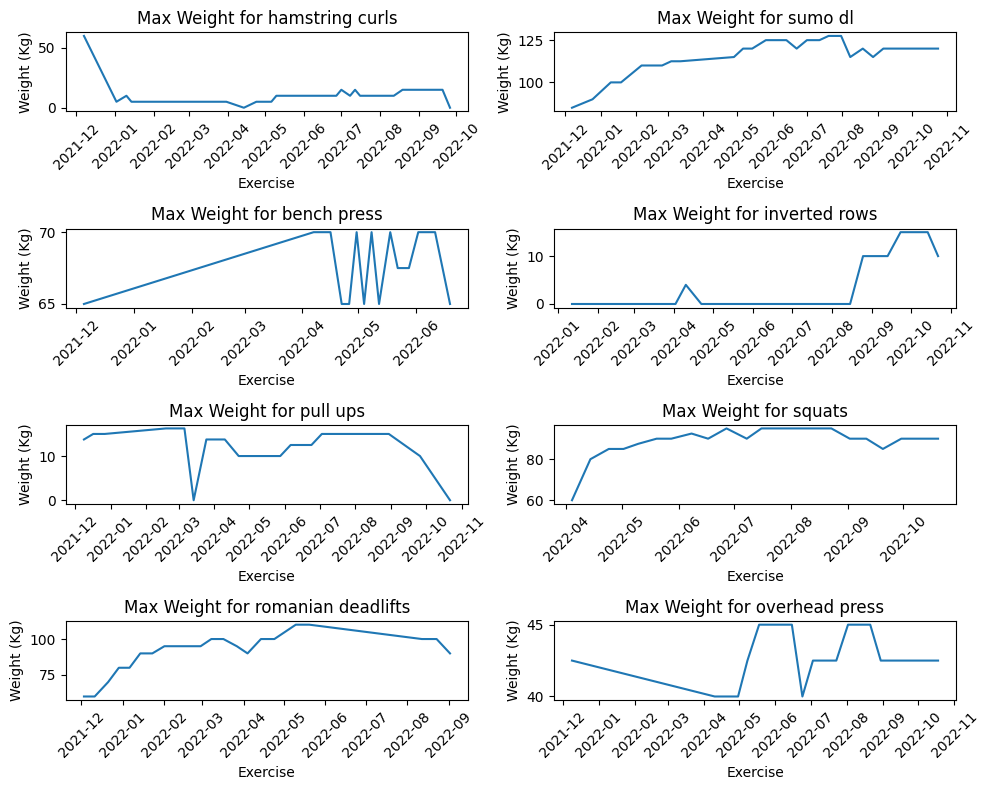

In [22]:
# Max Weight over time Linegraphs
exercise_names = [
    "hamstring curls",
    "sumo dl",
    "bench press",
    "inverted rows",
    "pull ups",
    "squats",
    "romanian deadlifts",
    "overhead press",
]

fig, axs = plt.subplots(4, 2, figsize=(10, 8))

for i, exercise_name in enumerate(exercise_names):
    row = i // 2
    col = i % 2
    exercise_df = df[df["exercise"] == exercise_name]
    exercise_df["max_weight"] = exercise_df.groupby("date")["weight"].transform("max")
    grouped_df = exercise_df.groupby("date")["max_weight"].max().reset_index()
    axs[row, col].plot(grouped_df["date"], grouped_df["max_weight"])
    axs[row, col].set_title(f"Max Weight for {exercise_name}")
    axs[row, col].set_xlabel("Exercise")
    axs[row, col].set_ylabel("Weight (Kg)")
    axs[row, col].tick_params(axis="x", rotation=45)


plt.tight_layout()
